In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
from cycler import cycler

from scipy.optimize import minimize

from scipy.stats import norm

from astropy.io import fits

from coprofile import COGenerator

from likelihood import ModelLikelihood

from function_likelihood import FunctionModelLikelihood, SampleInverter

import pyunfold as pu

from scipy.ndimage import convolve

In [2]:
colors = mpl.cm.viridis(np.linspace(0., 1., 5))

axes_style = { 'grid'      : 'True',
               'labelsize' : '14',
               'labelpad'  : '8.0',
               'prop_cycle': cycler('color', colors) }
grid_style = { 'alpha'     : '0.75',
               'linestyle' : ':' }
font_style = { 'size'      : '14' }

mpl.rc('font', **font_style)
mpl.rc('axes', **axes_style)
mpl.rc('grid', **grid_style)

In [3]:
fmu_neg, fmu_fast = 0.066, 0.072
f_ratio = fmu_fast/fmu_neg

In [4]:
mu_neg_file, mu_fast_file = 'models/balco_14co_delta_neg_models.fits', 'models/balco_14co_delta_fast_models.fits'

In [5]:
inverter = SampleInverter(m='step', f_ratio=f_ratio)

z = inverter.z
t = inverter.t
z_samp = inverter.z_samp
t_samp = inverter.t_samp

interp = inverter.interp

resolve = inverter.resolve

In [6]:
generator = COGenerator(mu_neg_file, mu_fast_file)

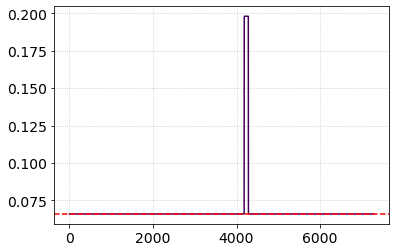

In [184]:
t_scale = (t-t[0])/(t[0]-t[-1])

amp = np.ones(len(t))

#amp += -0.1*t_scale
#amp += -0.5*np.sin(np.pi*t_scale)
amp[3000:3100] += 2.

f_neg = fmu_neg*amp
f_fast = fmu_fast*amp

plt.plot(t,f_neg)
plt.axhline(fmu_neg, ls='--', c='red')

In [185]:
# we need to flip f_neg and f_fast because the profile generator doesn't expect time to be in reverse order.
const_profile = generator.generate(f_neg = np.flip(f_neg), f_fast = np.flip(f_fast), rel_uncertainty=0.02)

Text(0.5, 1.0, 'Constant CO Profile Sample')

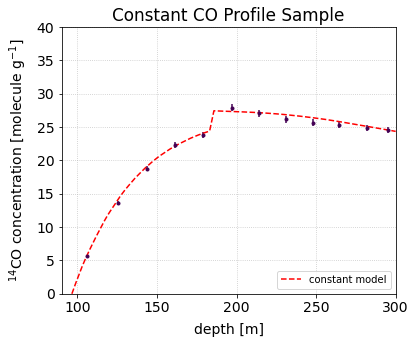

In [186]:
z_samp2, CO_samp, dCO_samp = const_profile.sample_z()

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,40),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample')

Text(0.5, 1.0, 'CO sample Inverted to f_mu_neg Solution')

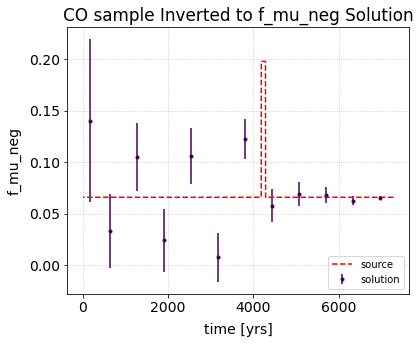

In [187]:
f_solve, df = inverter.solve(CO_samp, dCO_samp)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, f_neg, ls='--', c='red', label='source')
#ax.axhline(0.066, ls='--', c='red', label='source')
ax.errorbar(t_samp, f_solve, yerr=df, fmt='.', label='solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='lower right', fontsize=10)
plt.title('CO sample Inverted to f_mu_neg Solution')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fit')

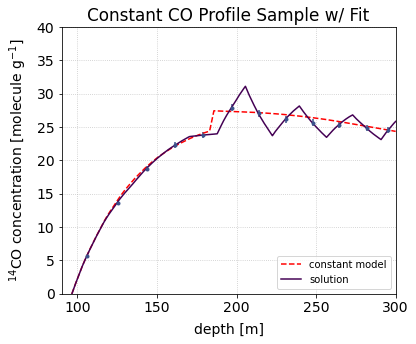

In [188]:
CO_solve = np.matmul(inverter.G, np.matmul(inverter.model, f_solve))

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(inverter.z[1:], CO_solve, label = 'solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,40),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fit')

In [189]:
const_params = 0.066+np.zeros(12)

B = inverter.likelihood(f_solve, CO_samp, dCO_samp) / inverter.likelihood(const_params, CO_samp, dCO_samp)

print('B_01 = {}'.format(B))

B_01 = 92712882.68995318


Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fits')

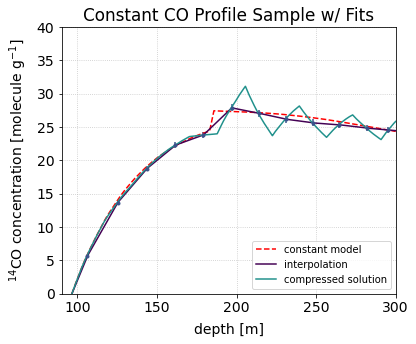

In [190]:
CO_interp = np.matmul(interp, CO_samp)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(z[1:], CO_interp, label = 'interpolation')
ax.plot(z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,40),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fits')

Text(0.5, 1.0, 'CO sample Inverted to f_mu_neg Solution')

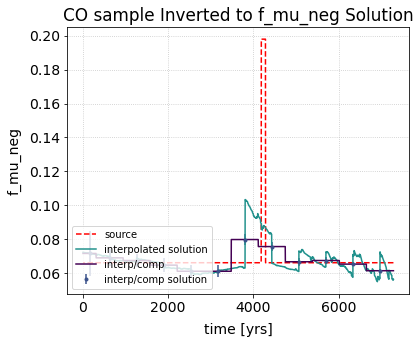

In [191]:
f_supersolve = np.matmul(inverter.G_inv, CO_interp)
f_resolve = np.matmul(inverter.tcomp, f_supersolve)
df_resolve = np.sqrt(np.sum((resolve * dCO_samp)**2,axis=1))

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, f_neg, ls='--', c='red', label='source')
#ax.axhline(0.066, ls='--', c='red', label='source')
ax.plot(t, f_supersolve, c=colors[2], label = 'interpolated solution')
ax.plot(t, np.matmul(inverter.model, f_resolve), label='interp/comp')
ax.errorbar(t_samp, f_resolve, yerr=df_resolve, fmt='.', label='interp/comp solution')
#ax.errorbar(t_samp, f_solve, yerr=df, c=colors[3], fmt='.', label='compressed solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='lower left', fontsize=10)
plt.title('CO sample Inverted to f_mu_neg Solution')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fit')

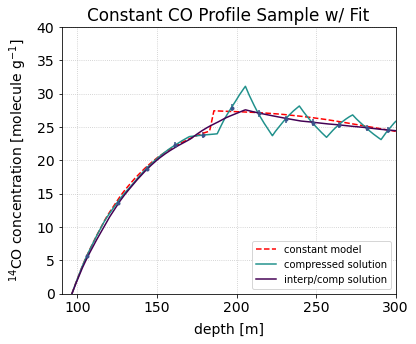

In [192]:
CO_resolve = np.matmul(inverter.G, np.matmul(inverter.model, f_resolve))


fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
ax.plot(inverter.z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.plot(inverter.z[1:], CO_resolve, label = 'interp/comp solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,40),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fit')

In [193]:
const_params = 0.066+np.zeros(12)

B = inverter.likelihood(f_resolve, CO_samp, dCO_samp) / inverter.likelihood(const_params, CO_samp, dCO_samp)

print('B_01 = {}'.format(B))

B_01 = 2662.4158660639123


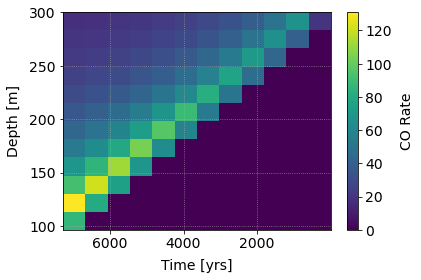

In [194]:
fig, ax = plt.subplots()
im = ax.imshow(inverter.G_comp, origin='lower', extent=[t[0],t[-1],z[0],z[-1]], aspect='auto')
cbar = plt.colorbar(im, label='CO Rate')
ax.set(xlabel='Time [yrs]', ylabel='Depth [m]')
plt.show()

In [195]:
unfolded_results = pu.iterative_unfold(data=CO_samp,
                                    data_err=dCO_samp,
                                    response=inverter.G_comp,
                                    response_err=np.sqrt(abs(inverter.G_comp)),
                                    efficiencies=np.sum(inverter.G_comp, axis=0),
                                    efficiencies_err=np.sum(inverter.G_comp, axis=0)*0.02,
                                    callbacks=[pu.Logger()],
                                    ts_stopping = 0.001)

Iteration 1: ts = 0.0020, ts_stopping = 0.001
Iteration 2: ts = 0.0019, ts_stopping = 0.001
Iteration 3: ts = 0.0017, ts_stopping = 0.001
Iteration 4: ts = 0.0014, ts_stopping = 0.001
Iteration 5: ts = 0.0012, ts_stopping = 0.001
Iteration 6: ts = 0.0010, ts_stopping = 0.001


C:\Users\walte\anaconda3\lib\site-packages\pyunfold\mix.py:64: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(cvm.diagonal())


Text(0.5, 1.0, 'CO sample Unfolded to f_mu_neg Solution')

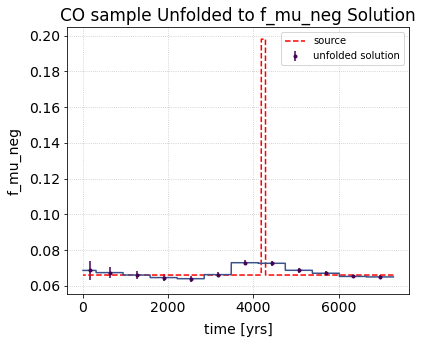

In [196]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, f_neg, ls='--', c='red', label='source')
#ax.axhline(0.066, ls='--', c='red', label='source')
#ax.scatter(t_samp, unfolded_results['unfolded'], label='unfolded solution')
ax.errorbar(t_samp, unfolded_results['unfolded'], yerr=unfolded_results['stat_err'], fmt='.', label='unfolded solution')
ax.plot(t, np.matmul(inverter.model, unfolded_results['unfolded']))
#ax.bar(t_samp, unfolded_results['unfolded'])
#ax.errorbar(t_samp, f_resolve, yerr=df_resolve, fmt='.', label='interp/comp solution')
#ax.errorbar(t_samp, f_solve, yerr=df, c=colors[3], fmt='.', label='compressed solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='upper right', fontsize=10)
plt.title('CO sample Unfolded to f_mu_neg Solution')

Text(0.5, 1.0, 'CO sample Unfolded to f_mu_neg Solution')

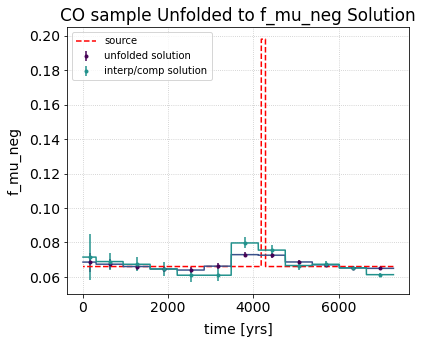

In [197]:
fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
#ax.axhline(0.066, ls='--', c='red', label='source')
ax.plot(t, f_neg, ls='--', c='red', label='source')
#ax.scatter(t_samp, unfolded_results['unfolded'], label='unfolded solution')
ax.errorbar(t_samp, unfolded_results['unfolded'], yerr=unfolded_results['stat_err'], fmt='.', label='unfolded solution')
ax.plot(t, np.matmul(inverter.model, unfolded_results['unfolded']))
ax.errorbar(t_samp, f_resolve, yerr=df_resolve, c=colors[2], fmt='.', label='interp/comp solution')
ax.plot(t, np.matmul(inverter.model, f_resolve))
#ax.errorbar(t_samp, f_solve, yerr=df, c=colors[3], fmt='.', label='compressed solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='upper left', fontsize=10)
plt.title('CO sample Unfolded to f_mu_neg Solution')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fit')

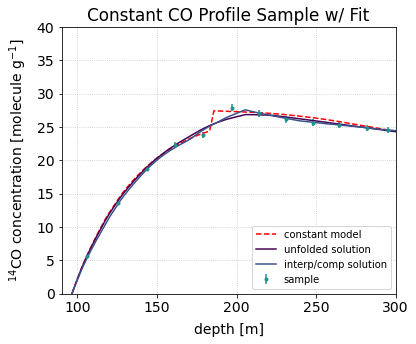

In [198]:
CO_unfold = np.matmul(inverter.G, np.matmul(inverter.model, unfolded_results['unfolded']))


fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z, const_profile.CO, 'r--', label='constant model')
#ax.plot(inverter.z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.plot(inverter.z[1:], CO_unfold, label = 'unfolded solution')
ax.plot(inverter.z[1:], CO_resolve, label = 'interp/comp solution')
ax.errorbar(z_samp2, CO_samp, yerr=dCO_samp, fmt='.', label='sample')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(0,40),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fit')

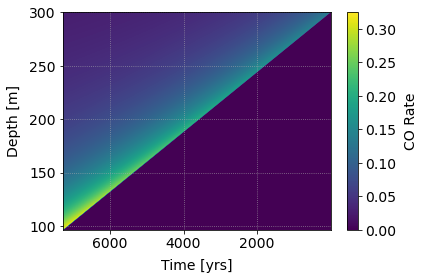

In [199]:
fig, ax = plt.subplots()
im = ax.imshow(inverter.G, origin='lower', extent=[t[0],t[-1],z[0],z[-1]], aspect='auto')
cbar = plt.colorbar(im, label='CO Rate')
ax.set(xlabel='Time [yrs]', ylabel='Depth [m]')
plt.show()

In [200]:
CO_tot = np.sum(CO_samp*np.diff(inverter.i))
f_avg = CO_tot / np.sum(inverter.G)
print(f_avg)

CO_mod = const_profile.CO[1:] - np.matmul(inverter.G, f_avg*np.ones(len(t)))
CO_samp_mod = CO_samp - np.matmul(inverter.comp, np.matmul(inverter.G, f_avg*np.ones(len(t))))

0.06728542125665139


Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fits')

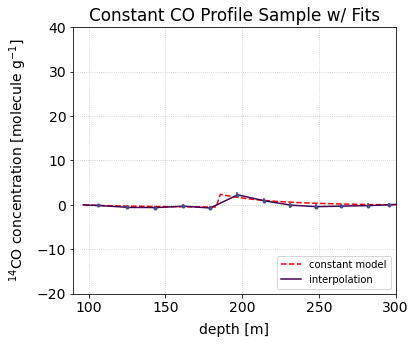

In [201]:
CO_interp = np.matmul(interp, CO_samp_mod)

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z[1:], CO_mod, 'r--', label='constant model')
ax.plot(z[1:], CO_interp, label = 'interpolation')
#ax.plot(z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.errorbar(z_samp2, CO_samp_mod, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(-20,40),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fits')

Text(0.5, 1.0, 'CO sample Inverted to f_mu_neg Solution')

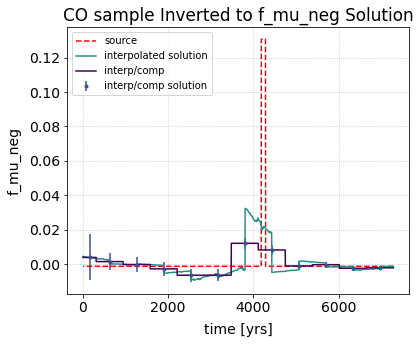

In [202]:
f_supersolve = np.matmul(inverter.G_inv, CO_interp)
f_resolve = np.matmul(inverter.tcomp, f_supersolve)
df_resolve = np.sqrt(np.sum((resolve * dCO_samp)**2,axis=1))

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(t, f_neg-f_avg, ls='--', c='red', label='source')
#ax.axhline(0.066, ls='--', c='red', label='source')
ax.plot(t, f_supersolve, c=colors[2], label = 'interpolated solution')
ax.plot(t, np.matmul(inverter.model, f_resolve), label='interp/comp')
ax.errorbar(t_samp, f_resolve, yerr=df_resolve, fmt='.', label='interp/comp solution')
#ax.errorbar(t_samp, f_solve, yerr=df, c=colors[3], fmt='.', label='compressed solution')
ax.set(xlabel='time [yrs]',
        ylabel='f_mu_neg')
ax.legend(loc='upper left', fontsize=10)
plt.title('CO sample Inverted to f_mu_neg Solution')

Text(0.5, 1.0, 'Constant CO Profile Sample w/ Fit')

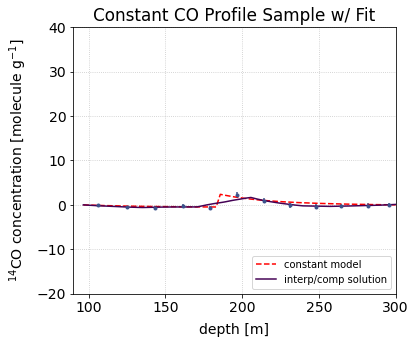

In [203]:
CO_resolve = np.matmul(inverter.G, np.matmul(inverter.model, f_resolve))

fig, ax = plt.subplots(1,1, figsize=(6,5), tight_layout=True)
ax.plot(const_profile.z[1:], CO_mod, 'r--', label='constant model')
#ax.plot(inverter.z[1:], CO_solve, c=colors[2], label = 'compressed solution')
ax.plot(inverter.z[1:], CO_resolve, label = 'interp/comp solution')
ax.errorbar(z_samp2, CO_samp_mod, yerr=dCO_samp, fmt='.')
ax.set(xlim=(90,300),
        xlabel='depth [m]',
        ylim=(-20,40),
        ylabel=r'$^{14}$CO concentration [molecule g$^{-1}$]')
ax.legend(loc='lower right', fontsize=10)
plt.title('Constant CO Profile Sample w/ Fit')